In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [6]:
data = pd.read_csv('processed_train.csv')
data.head()

,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,...,Platform_windows8,Processor_x64,Processor_x86,Census_DeviceFamily_Windows.Server,Census_OSArchitecture_arm64,Census_OSArchitecture_x86,Census_GenuineStateName_IS_GENUINE,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN,HasDetections
0,0.552153,0.530941,0.587952,7.0,0,53447.0,1.0,1.0,1,29,...,0,1,0,0,0,0,1,0,0,0
1,0.448751,0.528931,0.484434,7.0,0,53447.0,1.0,1.0,1,93,...,0,1,0,0,0,0,0,1,0,0
2,0.552153,0.530941,0.557522,7.0,0,53447.0,1.0,1.0,1,86,...,0,1,0,0,0,0,1,0,0,0
3,0.552153,0.530941,0.482759,7.0,0,53447.0,1.0,1.0,1,97,...,0,1,0,0,0,0,1,0,0,0
4,0.493175,0.530941,0.505721,7.0,0,53447.0,1.0,1.0,1,164,...,0,1,0,0,0,0,1,0,0,0


Разобьем выборку на тест и трейн

In [7]:
from sklearn.model_selection import train_test_split

X = data.drop('HasDetections', axis=1)
y = data['HasDetections']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=33)

Обучите LogReg и SVM с помощью классов `LogisticRegression` и `LinearSVC`. Добавьте шаг стандартизации данных в пайплайны. Для разнообразия, возьмем `MinMaxScaler`. Пайплайны запишем в переменные `pipe_lr` и `pipe_svm` соответственно!

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler

### Your code is here
pipe_svm = Pipeline([('scaler', MinMaxScaler()),
                    ('SVM', LinearSVC())])
pipe_lr = Pipeline([('scaler', MinMaxScaler()),
                 ('SVM', LogisticRegression())])



In [46]:
### Обучаем модели на трейне
### Your code is here

pipe_svm.fit(X_train, y_train)
pipe_lr.fit(X_train, y_train)



TypeError: Pipeline.score() missing 1 required positional argument: 'X'

In [48]:
print(f"lr score: {round(pipe_lr.score(X_test, y_test), 3)}, svm score: {round(pipe_svm.score(X_test, y_test), 3)}")

lr score: 0.843, svm score: 0.84


Постройте ROC для обеих моделей, посчитайте AUC . Конечно же, обучение проводите на трейне, а замеры - на тесте.

Заметьте! Классическая реализация `SVM`, как и в лекциях, не дает никакой оценки вероятности. Чтобы трансформировать выходы в вероятности, на практике мы использовали функцию-сигмоиду. Здесь предлагаем Вам трансформировать выходы `decision_function` в вероятности пропорциональным способом.

Например, вы обучили `SVM`, и на тестовых данных модель выдала следующие выходы `decision_function`:

(-10, -5, 0, +2, +10, +15)

Для каждого числа необходимо сделать преобразование в выражение вида `P(y = +1 | x)`.

С одной стороны, отрицательный знак числа будет сигнализировать нам о том, что `P(y = +1 | x) < 0.5`.

Тогда положительный о том, что `P(y = +1 | x) > 0.5`. 

С другой стороны, для тех объектов, в которых модель уверена больше всего, положим краевые вероятности. Для примера выше:

`P(y = +1 | -10) = 0`, `P(y = +1 | +15) = 1`. Для всех промежуточных объектов применим пропорциональное преобразование. Например:

$$
P(y = +1 | -5) = \frac{|-5-(-10)|}{|-10|} \cdot 0.5
$$

$$
P(y = +1 | +2) = \frac{|+2|}{|+15|} \cdot 0.5 + 0.5
$$
Таким образом мы можем перевести выходы SVM в отрезок [0;1] и попробовать интерпретировать новые числа как вероятности, чтобы изобразить калибровочную кривую. При таком преобразовании пропорции внутри первоначально отрицательных и внутри положительных чисел сохраняются.

In [14]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

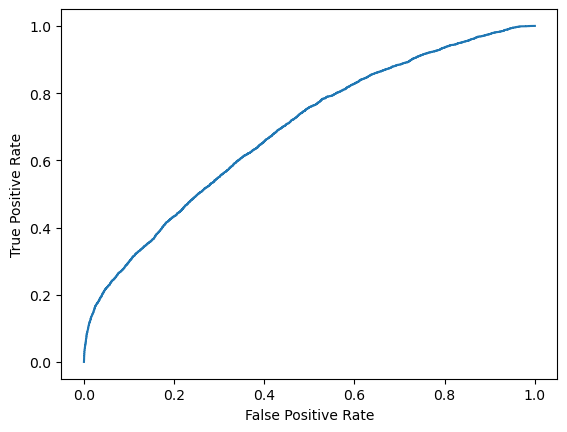

In [19]:
### С изображением рок-кривой для ЛогРега не будет проблем:
### Your code is here

fpr_lr, tpr_lr, trash_lr = roc_curve(y_test, pipe_lr.predict_proba(X_test)[:, 1])
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

[0.34268039 0.30930055 0.28823352 ... 0.28217437 0.3293939  0.27896763] 0.0 1.0


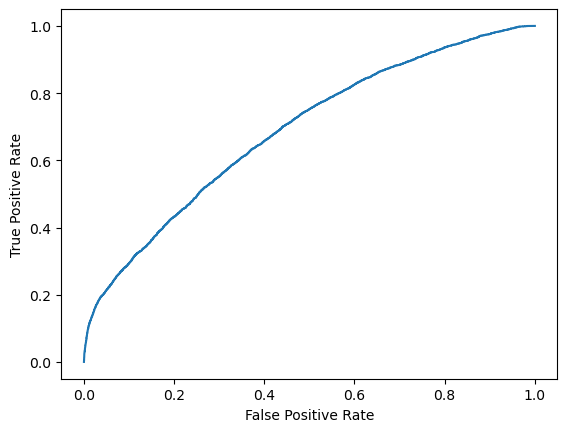

In [49]:
### А для того, чтобы построить и изобразить рок-кривую для SVM, придется
### в начале преобразовать выходы pipe_svm.decision_function

### Your code is here

def transform(predict_list):
    max_num = max(predict_list)
    min_num = min(predict_list)
#     max_num_indx[predict_list.index(max_num)] = 1
#     min_num_indx[predict_list.index(min_num)] = 0
    
    for i in range(len(predict_list)):
        num = predict_list[i]
        if num <= 0:
            predict_list[i] = abs(min_num - num) * 0.5 / abs(min_num) 
        else:
            predict_list[i] = abs(num) * 0.5 / max_num + 0.5
    return predict_list

predict_transform = transform(pipe_svm.decision_function(X_test))

print(predict_transform, min(predict_transform), max(predict_transform))

fpr_svm, tpr_svm, trash_svm = roc_curve(y_test, predict_transform)
RocCurveDisplay(fpr=fpr_svm, tpr=tpr_svm).plot()

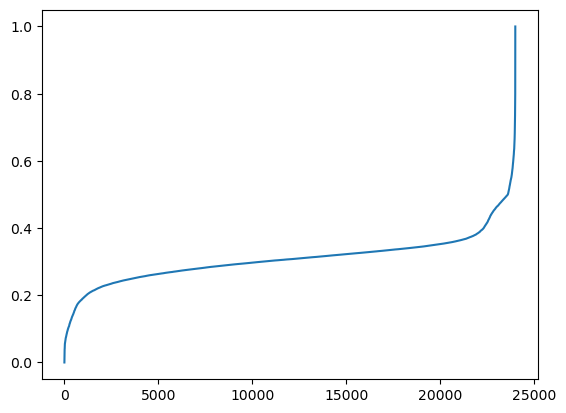

In [42]:
# import matplotlib.pyplot as plt
# predict_transform.sort()
# y = predict_transform
# x = [int(i) for i in range(len(predict_transform))]
# plt.plot(x, y)

In [54]:
from sklearn.metrics import auc 

### Your code is here


print(f'AUC lr = {auc(fpr_lr, tpr_lr)} \nAUC svm = {auc(fpr_svm, tpr_svm)}')


AUC lr = 0.689056400232108 
AUC svm = 0.6877919839699904


Постройте калибровочные кривые для обеих моделей. Методом from_estimator для svm воспользоваться не получится.

In [45]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve


### Your code is here

calibration_curve(y_test, predict_transform)


(array([0.03333333, 0.14896134, 0.45627376, 0.84761905, 1.        ]),
 array([0.1483153 , 0.30313517, 0.47097597, 0.65464607, 0.94561552]))

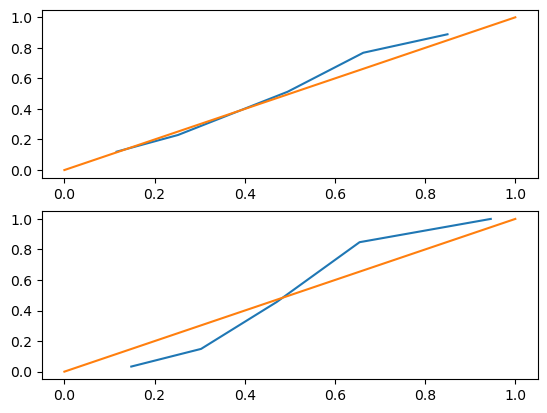

In [58]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve


### Your code is here

prob_true_lr, prob_pred_lr = calibration_curve(y_test, pipe_lr.predict_proba(X_test)[:, 1])
prob_true_svm, prob_pred_svm = calibration_curve(y_test, predict_transform)

plt.figure()
plt.s
plt.subplot(2, 1, 1)
plt.plot(prob_pred_lr, prob_true_lr)
x = np.linspace(0, 1, 100)
plt.plot(x, x)
plt.subplot(2, 1, 2)
plt.plot(prob_pred_svm, prob_true_svm)
plt.plot(x, x)

plt.show()

**Какая калибровочная кривая ближе к диагонали?  Откалибруйте SVM способом как в практике и изобразите новую кривую!

In [60]:
### Калибровка

from sklearn.calibration import CalibratedClassifierCV

### Your code is here
calibration = CalibratedClassifierCV(pipe_svm, cv=5, method='sigmoid')
calibration.fit(X_train, y_train)

calibrated_probs = calibration.predict_proba(X_test)[:, 1]




In [71]:
calibration_iso = CalibratedClassifierCV(pipe_svm, cv=5, method='isotonic')
calibration_iso.fit(X_train, y_train)

calibrated_probs_iso = calibration_iso.predict_proba(X_test)[:, 1]



               Without colibration                           
               Colibration sigmoid                           
               Colibration isotonic                           
               LogReg                           


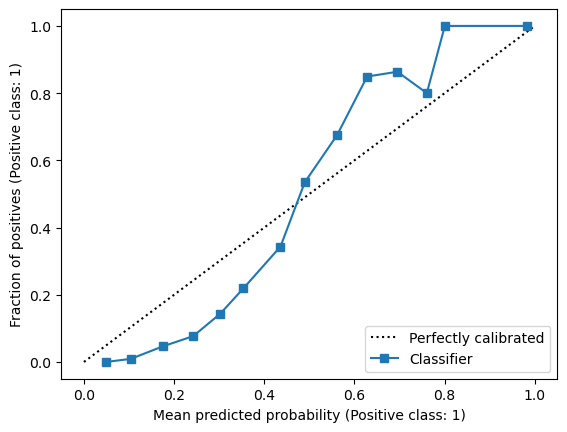

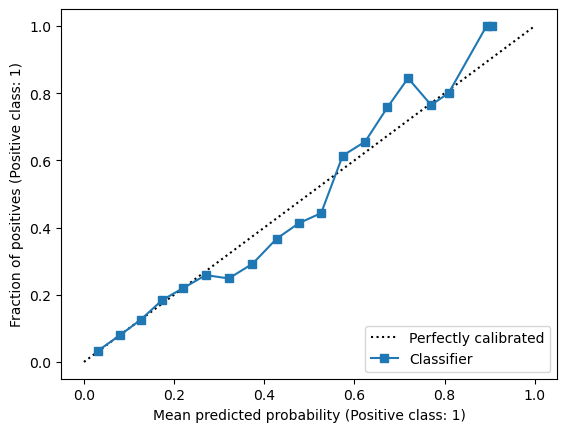

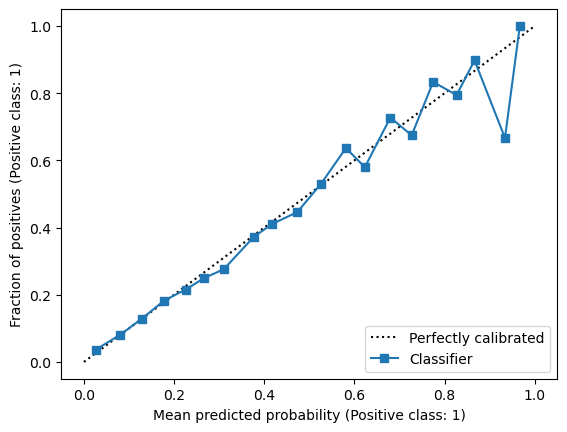

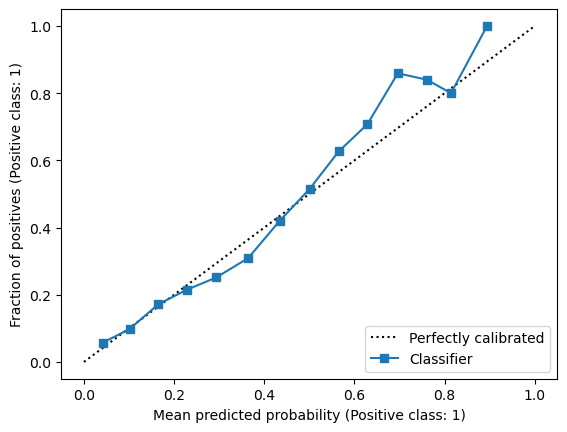

In [72]:
### Новая кривая
from sklearn.calibration import CalibrationDisplay
### Your code is here
print("               Without colibration                           ")
CalibrationDisplay.from_predictions(y_test, predict_transform, n_bins=15)
print("               Colibration sigmoid                           ")
CalibrationDisplay.from_predictions(y_test, calibrated_probs, n_bins=20)

print("               Colibration isotonic                           ")
CalibrationDisplay.from_predictions(y_test, calibrated_probs_iso, n_bins=20)

print("               LogReg                           ")
CalibrationDisplay.from_predictions(y_test, pipe_lr.predict_proba(X_test)[:, 1], n_bins=15)